# Predicting cause of death from PHMRC VA text narratives using BERT
References: <br>
https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb <br>
https://medium.com/@roshmitadey/understanding-language-modeling-from-n-grams-to-transformer-based-neural-models-d2bdf1532c6d

In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import json
from tqdm.auto import tqdm
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import TFBertModel

import warnings
warnings.filterwarnings("ignore")

2024-02-26 07:47:33.014407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
# GitHub CSV file URL
url = 'https://raw.githubusercontent.com/avisokay/va_nlp/main/data/phmrc/phmrc_adult_tokenized.csv'
df = pd.read_csv(url)

In [3]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['tags'],df['gs_cod'],test_size=0.3)

In [4]:
# just age covariate
Test_X_covariates = df.loc[Test_X.index]['age_yr']

In [6]:
# train
# Read in CSV files and store in dictionary
train_excluded_dict = {}
for region in regions:
    file_path = f'https://raw.githubusercontent.com/avisokay/va_nlp/main/data/train_test_val/train_ex_{region.lower()}.csv'
    train_excluded_dict[region] = pd.read_csv(file_path)
    
# assign training data df names
train_ex_ap = train_excluded_dict['ap']
train_ex_dar = train_excluded_dict['dar']
train_ex_pemba = train_excluded_dict['pemba']
train_ex_mexico = train_excluded_dict['mexico']
train_ex_bohol = train_excluded_dict['bohol']
train_ex_up = train_excluded_dict['up']

In [7]:
# test / val

# Dictionary to store DataFrames
test_dict = {}
val_dict = {}

# Read in test and validation CSV files and store in dictionaries
for region in regions:
    test_file_path = f'../../data/train_test_val/test_{region}.csv'
    val_file_path = f'../../data/train_test_val/val_{region}.csv'
    
    test_dict[region] = pd.read_csv(test_file_path)
    val_dict[region] = pd.read_csv(val_file_path)

In [8]:
# assign test and val data df names
test_ap = test_dict['ap']
test_dar = test_dict['dar']
test_pemba = test_dict['pemba']
test_mexico = test_dict['mexico']
test_bohol = test_dict['bohol']
test_up = test_dict['up']

val_ap = val_dict['ap']
val_dar = val_dict['dar']
val_pemba = val_dict['pemba']
val_mexico = val_dict['mexico']
val_bohol = val_dict['bohol']
val_up = val_dict['up']

## RUN ON ONE SITE AT A TIME

In [42]:
df['site'].unique()

array(['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba'], dtype=object)

In [45]:
site_excluded = 'mexico'

Train_X = df[df['site'] != site_excluded]['tags']
Test_X = df[df['site'] == site_excluded]['tags']
Train_Y = df[df['site'] != site_excluded]['gs_cod']
Test_Y = df[df['site'] == site_excluded]['gs_cod']
Test_X_covariates = df[df['site'] == site_excluded]['age_yr']

Test_X_covariates.to_csv(f'{site_excluded}_covariates.csv', index=False)

In [46]:
## Pre-processing

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# create empty vectors for storing id and masks
X_input_ids = np.zeros((len(Train_X), 256))
X_attn_masks = np.zeros((len(Train_X), 256))

# # for inputting whole dataframe
# def generate_training_data(df, ids, masks, tokenizer):
#     for i, text in tqdm(enumerate(df['narrative'])):
#         tokenized_text = tokenizer.encode_plus(
#             text,
#             max_length=256, 
#             truncation=True, 
#             padding='max_length', 
#             add_special_tokens=True,
#             return_tensors='tf'
#         )
#         ids[i, :] = tokenized_text.input_ids
#         masks[i, :] = tokenized_text.attention_mask
#     return ids, masks

# for inputting a specific list of narratives
def generate_training_data(narratives, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(narratives)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

X_input_ids, X_attn_masks = generate_training_data(Train_X, X_input_ids, X_attn_masks, tokenizer)

# create one-hot encoded target tensor from output classes
nominal_vector = np.array(Train_Y).reshape(-1, 1)

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the nominal vector
labels = encoder.fit_transform(nominal_vector)

# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy training
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

# map function to return correct batch
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

# converting to required format for tensorflow dataset 
dataset = dataset.map(SentimentDatasetMapFunction)

# batch size, drop any left out tensor
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) 

# for each 16 batch of data we will have len(df)//16 samples, 80/20 train test split
p = 0.8
train_size = int((len(Train_X)//16)*p) 

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Build the BERT model

model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

# defining 2 input layers for input_ids and attn_masks
layers = len(Train_Y.unique())

input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(layers, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

cod_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
# cod_model.summary()

# loss function, optimizer, and accuracy matrix 
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

cod_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

## Train BERT model

# LONG RUN TIME
hist = cod_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = 1 # can use more epochs (20-25) on better machine with good GPU
)

cod_model.save(f'../../models/bert_cod_{site_excluded}')

0it [00:00, ?it/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                     

INFO:tensorflow:Assets written to: ../../models/bert_cod_mexico/assets


## Prediction with BERT model

In [49]:
# load model from memory
cod_model = tf.keras.models.load_model('../../models/bert_cod_mexico/')

In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

unique_cod = list(np.unique(df['gs_cod'].values))

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=unique_cod):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

## Tester

In [26]:
# input_text = input('Enter death narrative here: ')
# processed = prepare_data(input_text, tokenizer)
# result = make_prediction(cod_model, processed_data=processed)
# print(f"Predicted cause of death: {result}")

Enter death narrative here: he was in the car and ran into another car. it was an accident. 
1/1 [==============================] - 4s 4s/step
Predicted cause of death: non-communicable disease


## Predict with BERT

In [51]:
# SLOW
predictions_bert_text = []
for narrative in tqdm(Test_X):
    processed = prepare_data(narrative, tokenizer)
    predictions_bert_text.append(make_prediction(cod_model, processed_data=processed))

  0%|          | 0/1306 [00:00<?, ?it/s]

1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 337ms/step


## Convert strings to embeddings using dictionary

In [95]:
# Load the dictionary from the JSON file
with open('../classic_nlp/cod_embeddings.json', 'r') as file:
    loaded_dict = json.load(file)

# Convert string keys back to integers
cod_embeddings = {int(key): value for key, value in loaded_dict.items()}

# Convert the list of strings to a list of integer embeddings using the dictionary
predictions_bert_embedding = pd.Series([key for value in predictions_bert_text for key, string_value in cod_embeddings.items() if string_value == value])
Test_Y_embedding = pd.Series([int(key) for item in Test_Y for key, value in loaded_dict.items() if value == item])

# combine true labels, predictions, covariates into one df and save results
results_df = pd.DataFrame({'Y': list(predictions_bert_embedding), 
                           'Y_hat': list(predictions_bert_embedding),
                           'X': list(Test_X_covariates)})

# write out to csv
results_df.to_csv(f'../../data/results/{site_excluded}_bert.csv', index=False)

## Compute and Compare Accuracy

In [30]:
predictions_bert = pd.read_csv('predictions_bert.csv')

In [33]:
predictions_classic = pd.read_csv('../classic_nlp/baseline_predictions.csv')

In [34]:
classic_predictions = predictions_classic.copy()
predictions_classic['predictions_bert'] = predictions_bert

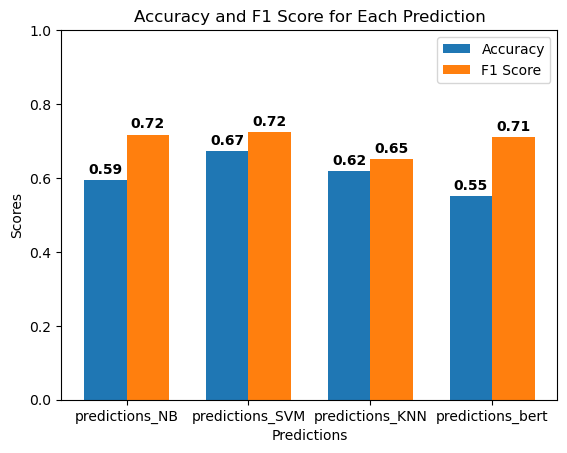

In [35]:
# Calculate accuracy and F1 score for each prediction column
columns_to_evaluate = ['predictions_NB', 'predictions_SVM', 'predictions_KNN', 'predictions_bert']
accuracy_scores = []
f1_scores = []

for column in columns_to_evaluate:
    accuracy = accuracy_score(predictions_classic[column], predictions_classic['Test_Y'])
    f1 = f1_score(predictions_classic[column], predictions_classic['Test_Y'] , average = 'weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(columns_to_evaluate))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Predictions')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Prediction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(columns_to_evaluate)
ax.legend()
# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Add scores on top of each bar
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    ax.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    ax.text(i + bar_width, f1 + 0.01, f'{f1:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [22]:
test = pd.read_csv('../../src/gpt_nlp/gpt35_fewshot_text.csv')

In [28]:
test['0'].value_counts()

0
non-communicable                                                                                                                                                                                                                                                                             2822
aids-tb                                                                                                                                                                                                                                                                                      1576
external                                                                                                                                                                                                                                                                                      967
I cannot provide a label without a narrative. Please provide a narrative for me to analyze.                                     

In [23]:
pd.Series(test)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [15]:
test

,0
0,non-communicable
1,non-communicable
2,non-communicable
3,non-communicable
4,non-communicable
...,...
6758,non-communicable
6759,non-communicable
6760,non-communicable
6761,external
